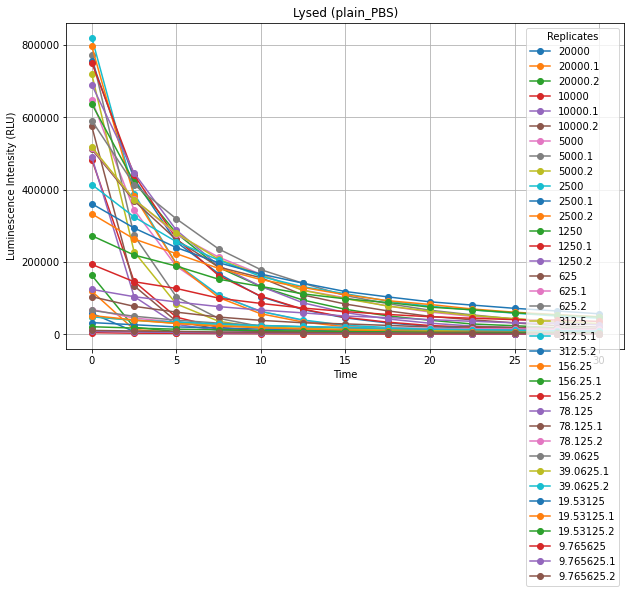

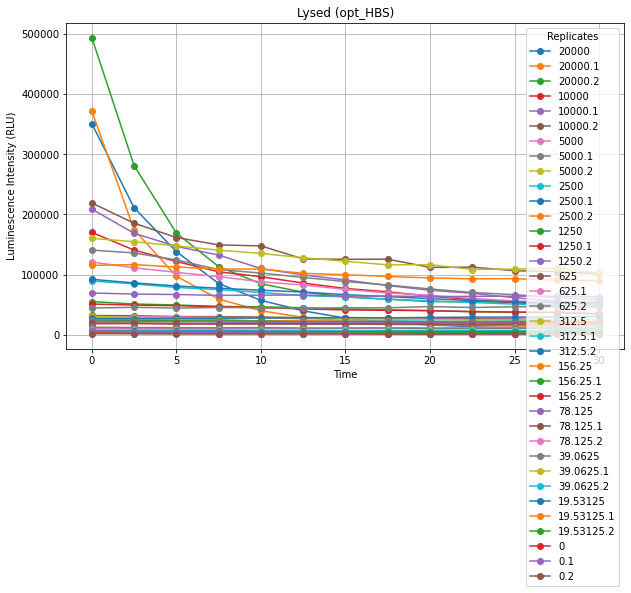

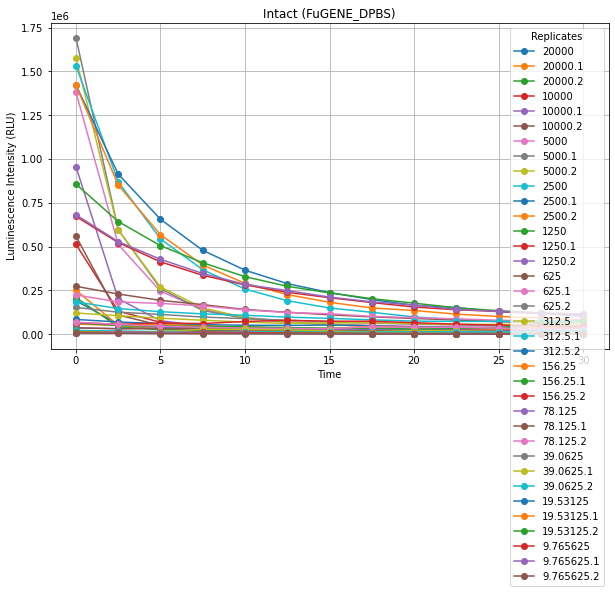

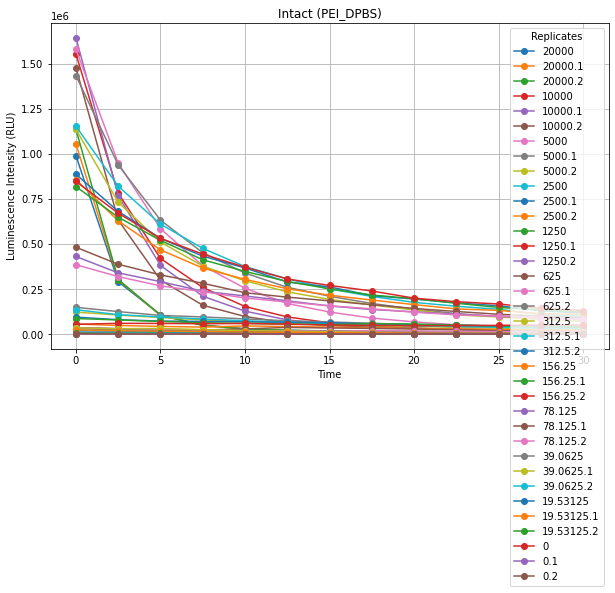

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file with all sheets
excel_file = 'NanoLuc.xlsx'
all_data = pd.read_excel(excel_file, sheet_name=None)

# Loop through each condition (sheet)
for condition, df in all_data.items():
    # Assume the first column is time and the remaining columns are replicates
    time = df.iloc[:, 0]  # time points
    data = df.iloc[:, 1:]  # RLU values for replicates

    plt.figure(figsize=(10, 6))
    for col in data.columns:
        plt.plot(time, data[col], marker='o', label=str(col))
    plt.title(condition)
    plt.xlabel("Time")
    plt.ylabel("Luminescence Intensity (RLU)")
    plt.legend(title='Replicates')
    plt.grid(True)
    plt.show()


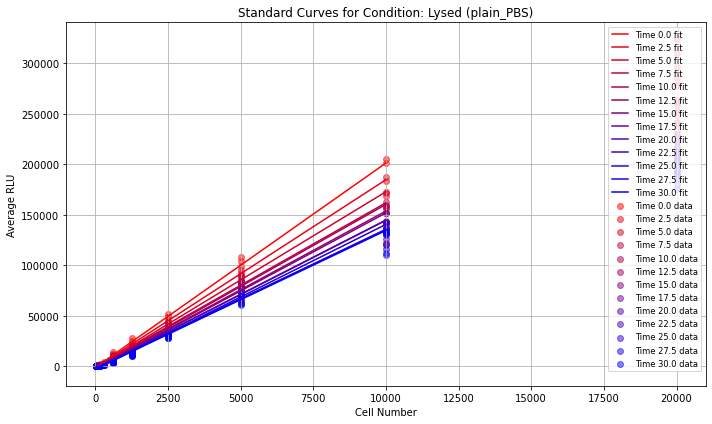

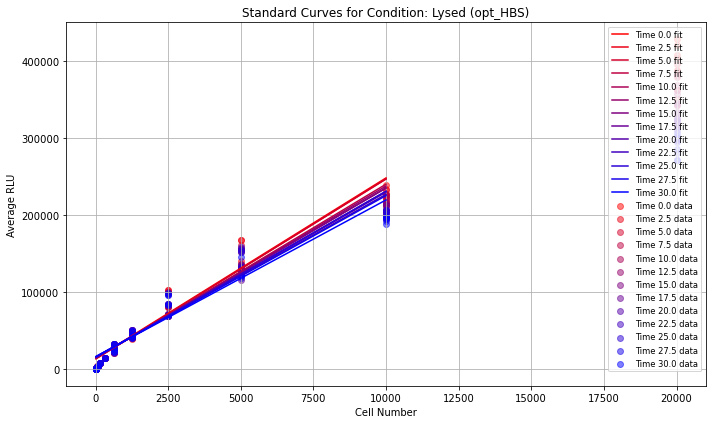

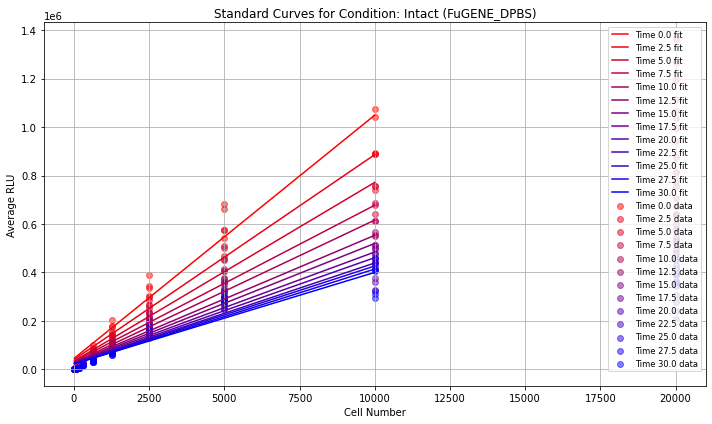

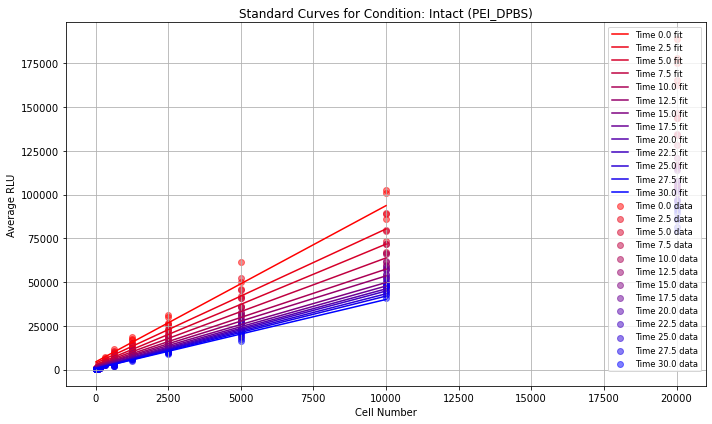

Fitting parameters saved to 'fitting_parameters.csv'


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import re
from matplotlib.colors import LinearSegmentedColormap

# --- Configuration parameters ---
excel_file = 'NeonGreen.xlsx'
min_points = 3  # minimum number of points required for regression

def extract_float(s):
    """
    Extract the first float number from a string.
    For example, '156.25.1' will return 156.25.
    """
    match = re.match(r"^\d+(?:\.\d+)?", s)
    if match:
        return float(match.group(0))
    else:
        raise ValueError(f"Cannot extract float from header: {s}")

# Read all sheets from the Excel file; each sheet corresponds to a condition.
sheets = pd.read_excel(excel_file, sheet_name=None)

# List to store fitting parameters for each condition and time point.
fit_results = []

# Process each condition (each sheet)
for condition, df in sheets.items():
    # The first row contains the header.
    # The first column contains time points.
    time_points = df.iloc[:, 0]
    
    # Process replicate columns (columns from index 1 onward).
    replicate_cols = df.columns[1:]
    # Extract the numeric part from each header (e.g. "156.25.1" becomes 156.25)
    new_names = [extract_float(str(col)) for col in replicate_cols]
    
    # Create a new DataFrame with updated column names.
    df_new = df.copy()
    df_new.columns = [df.columns[0]] + new_names  # first column remains unchanged
    
    # Group columns with the same cell number and average the triplicates.
    grouped = df_new.iloc[:, 1:].groupby(level=0, axis=1).mean()
    
    # Get the sorted unique cell numbers (x-values).
    cell_numbers = np.array(grouped.columns, dtype=float)
    sort_idx = np.argsort(cell_numbers)
    x_sorted = cell_numbers[sort_idx]
    
    # --- Set up a colormap for time points: red (early) to blue (late) ---
    cmap = LinearSegmentedColormap.from_list("red_to_blue", ["red", "blue"])
    norm = plt.Normalize(vmin=0, vmax=len(time_points)-1)
    
    plt.figure(figsize=(10, 6))
    
    # Process each time point (each row in the grouped DataFrame)
    for idx, t in enumerate(time_points):
        # Get color for this time point based on its order.
        color = cmap(norm(idx))
        
        # Get the averaged RLU values for this time point.
        y_vals = grouped.iloc[idx].values.astype(float)
        # Reorder the y-values according to the sorted cell numbers.
        y_sorted = y_vals[sort_idx]
        
        # --- Filter data: only include cell numbers in the fixed range [10, 10000] ---
        mask = (x_sorted >= 10) & (x_sorted <= 10000)
        if np.sum(mask) < min_points:
            # Not enough data points in the fixed range for a proper regression.
            continue
        
        x_fixed = x_sorted[mask]
        y_fixed = y_sorted[mask]
        
        # Perform linear regression on the fixed range.
        slope, intercept, r_value, p_value, std_err = linregress(x_fixed, y_fixed)
        r2 = r_value**2
        
        # Calculate additional regression parameters.
        x_intercept = -intercept / slope if slope != 0 else np.nan
        inv_slope = 1.0 / slope if slope != 0 else np.nan
        
        # Calculate Sy.x: the standard error of the estimate.
        y_fit = slope * x_fixed + intercept
        n = len(x_fixed)
        syx = np.sqrt(np.sum((y_fixed - y_fit)**2) / (n - 2)) if n > 2 else np.nan
        
        # Calculate LOD = 3.3 * Sy.x / slope.
        lod = 3.3 * syx / slope if slope != 0 else np.nan
        
        # Save the fitting parameters.
        fit_results.append({
            "Condition": condition,
            "Time": t,
            "Slope": slope,
            "Y-intercept": intercept,
            "X-intercept": x_intercept,
            "1/slope": inv_slope,
            "R squared": r2,
            "Sy.x": syx,
            "LOD": lod
        })
        
        # --- Plotting the data and fitted line ---
        # Scatter plot the averaged data points (all points for context).
        plt.scatter(x_sorted, y_sorted, color=color, alpha=0.5, label=f'Time {t} data')
        
        # Plot the fitted line over the fixed range.
        x_line = np.linspace(np.min(x_fixed), np.max(x_fixed), 100)
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, color=color, label=f'Time {t} fit')
    
    plt.title(f'Standard Curves for Condition: {condition}')
    plt.xlabel('Cell Number')
    plt.ylabel('Average RLU')
    plt.legend(fontsize='small', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Save all fitting parameters into a CSV file.
fit_df = pd.DataFrame(fit_results)
fit_df.to_csv('fitting_parameters.csv', index=False)
print("Fitting parameters saved to 'fitting_parameters.csv'")


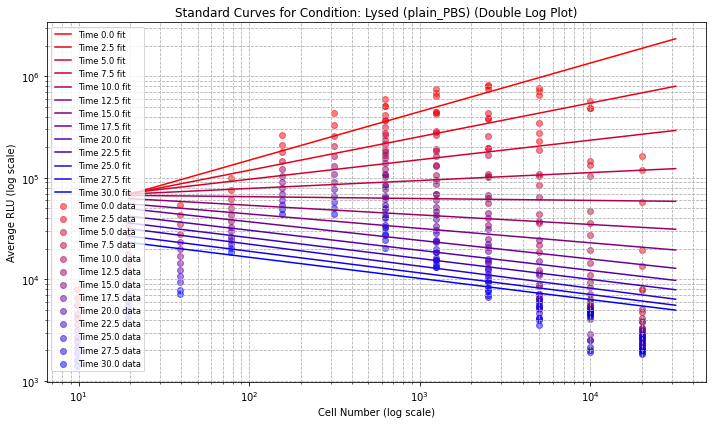

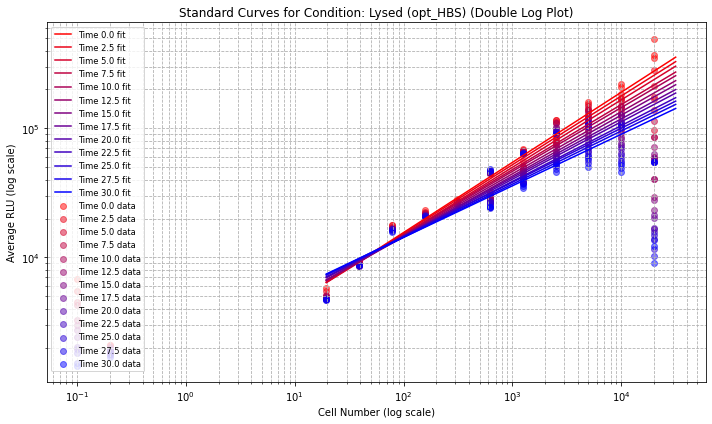

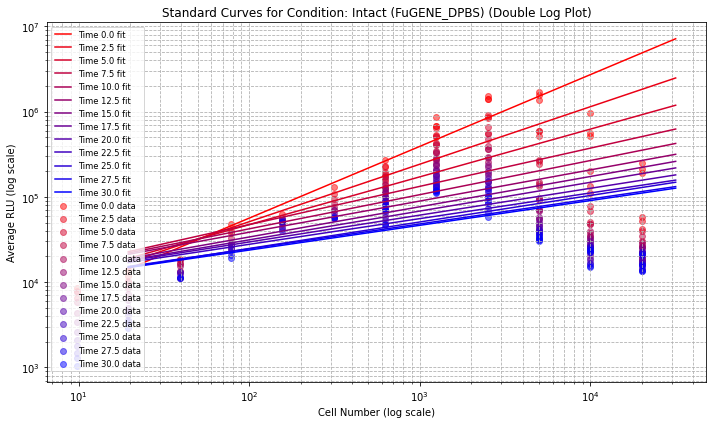

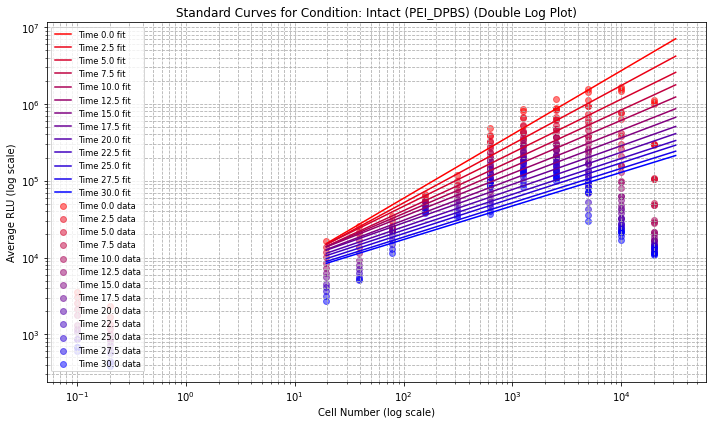

Fitting parameters saved to 'fitting_parameters2.csv'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import re
from matplotlib.colors import LinearSegmentedColormap

# --- Configuration parameters ---
excel_file = 'NanoLuc.xlsx'
min_points = 3  # minimum number of points required for regression

def extract_float(s):
    """
    Extract the first float number from a string.
    For example, '156.25.1' will return 156.25.
    """
    match = re.match(r"^\d+(?:\.\d+)?", s)
    if match:
        return float(match.group(0))
    else:
        raise ValueError(f"Cannot extract float from header: {s}")

# Read all sheets from the Excel file; each sheet corresponds to a condition.
sheets = pd.read_excel(excel_file, sheet_name=None)

# List to store fitting parameters for each condition and time point.
fit_results = []

# Process each condition (each sheet)
for condition, df in sheets.items():
    # The first column contains time points.
    time_points = df.iloc[:, 0]
    
    # Process replicate columns (columns from index 1 onward).
    replicate_cols = df.columns[1:]
    # Extract the numeric part from each header (e.g. "156.25.1" becomes 156.25)
    new_names = [extract_float(str(col)) for col in replicate_cols]
    
    # Create a new DataFrame with updated column names.
    df_new = df.copy()
    df_new.columns = [df.columns[0]] + new_names  # first column remains unchanged
    
    # Group columns with the same cell number and average the triplicates.
    grouped = df_new.iloc[:, 1:].groupby(level=0, axis=1).mean()
    
    # Get the sorted unique cell numbers (x-values).
    cell_numbers = np.array(grouped.columns, dtype=float)
    sort_idx = np.argsort(cell_numbers)
    x_sorted = cell_numbers[sort_idx]
    
    # --- Set up a colormap for time points: red (early) to blue (late) ---
    cmap = LinearSegmentedColormap.from_list("red_to_blue", ["red", "blue"])
    norm = plt.Normalize(vmin=0, vmax=len(time_points)-1)
    
    plt.figure(figsize=(10, 6))
    
    # Process each time point (each row in the grouped DataFrame)
    for idx, t in enumerate(time_points):
        # Assign a color based on time order.
        color = cmap(norm(idx))
        
        # Get the averaged RLU values for this time point.
        y_vals = grouped.iloc[idx].values.astype(float)
        # Reorder the y-values according to the sorted cell numbers.
        y_sorted = y_vals[sort_idx]
        
        # --- Filter data: only include cell numbers in the fixed range [10, 10000] ---
        mask = (x_sorted >= 10) & (x_sorted <= 10000)
        if np.sum(mask) < min_points:
            continue
        
        x_fixed = x_sorted[mask]
        y_fixed = y_sorted[mask]
        
        # --- Transform data to log10 scale ---
        log_x = np.log10(x_fixed)
        log_y = np.log10(y_fixed)
        
        # Perform linear regression on the log-transformed data.
        slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
        r2 = r_value**2
        
        # In the log–log model, we have: log10(y) = slope * log10(x) + intercept.
        # The x-intercept (in log scale) is when log10(y)=0:
        #   0 = slope * log10(x_int) + intercept  =>  log10(x_int) = -intercept/slope
        # Hence, the x-intercept in the original scale is:
        x_intercept = 10**(-intercept/slope) if slope != 0 else np.nan
        inv_slope = 1.0 / slope if slope != 0 else np.nan
        
        # Standard error of the estimate in log space.
        y_fit = slope * log_x + intercept
        n = len(log_x)
        syx = np.sqrt(np.sum((y_fixed - 10**y_fit)**2) / (n - 2)) if n > 2 else np.nan
        
        # Limit of Detection in log space.
        lod = 3.3 * syx / slope if slope != 0 else np.nan
        
        # Save the fitting parameters.
        fit_results.append({
            "Condition": condition,
            "Time": t,
            "Slope": slope,
            "Y-intercept (log scale)": intercept,
            "X-intercept": x_intercept,
            "1/slope": inv_slope,
            "R squared": r2,
            "Sy.x": syx,
            "LOD": lod
        })
        
        # --- Plotting ---
        # Plot the data points (in original scale). 
        plt.scatter(x_sorted, y_sorted, color=color, alpha=0.5, label=f'Time {t} data')
        
        # Create fitted line points in the log domain.
        log_x_line = np.linspace(np.min(log_x), 4.5, 200)
        log_y_line = slope * log_x_line + intercept
        # Convert back to original scale for plotting.
        x_line = 10**(log_x_line)
        y_line = 10**(log_y_line)
        plt.plot(x_line, y_line, color=color, label=f'Time {t} fit')
    
    # Set both axes to logarithmic scale.
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Standard Curves for Condition: {condition} (Double Log Plot)')
    plt.xlabel('Cell Number (log scale)')
    plt.ylabel('Average RLU (log scale)')
    plt.legend(fontsize='small', loc='best')
    plt.grid(True, which='both', ls='--')
    plt.tight_layout()
    plt.show()

# Save all fitting parameters into a CSV file.
fit_df = pd.DataFrame(fit_results)
fit_df.to_csv('NanoLuc_fitting_parameters2.csv', index=False)
print("Fitting parameters saved to 'fitting_parameters2.csv'")
